### Useful links
[DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning](http://moreisdifferent.com/2017/9/21/DIY-Drug-Discovery-using-molecular-fingerprints-and-machine-learning-for-solubility-prediction/)

[RDKit_Overview](http://www.rdkit.org/RDKit_Overview.pdf)

In [1]:
from rdkit import Chem
from rdkit.Chem.EState import Fingerprinter
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pandas
import numpy

In [2]:
dataset = pandas.read_excel("dataset.xlsx")

In [3]:
# From the main dataset, split into training and test dataframes
training_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Tr"]
test_set = dataset.loc[dataset['Tr=traning set\nTe=test set'] == "Te"]

# Trim Wang's (2015) predicted values since we are calculating these ourselves
training_set = training_set.iloc[:,0:4]
test_set = test_set.iloc[:,0:4]

# Convert SMILES into molecule objects in new col
# training_set['Mol'] = training_set['SMILES structure'].apply(Chem.MolFromSmiles)
# test_set['Mol'] = training_set['SMILES structure'].apply(Chem.MolFromSmiles)

training_set.head()
print("Training set has {} items, test set has {} items".format(training_set.iloc[:,0].count(), test_set.iloc[:,0].count()))

Training set has 904 items, test set has 226 items


In [4]:
list(training_set)

['NO',
 'Tr=traning set\nTe=test set',
 'SMILES structure',
 'experimental logD7.4']

In [5]:
training_set.head()

,NO,Tr=traning set Te=test set,SMILES structure,experimental logD7.4
1,A-logD7.4-100,Tr,Fc1cc2c(N(C=C(C(O)=O)C2=O)C2CC2)cc1N1CCNCC1,-0.96
2,A-logD7.4-101,Tr,S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1,-0.92
3,A-logD7.4-104,Tr,OC=1C(=O)C=CN(CCCO)C=1C,-0.90
4,A-logD7.4-105,Tr,Fc1cc2c(N(C=C(C(O)=O)C2=O)c2ccccc2C)cc1N1CCNCC1,-0.83
5,A-logD7.4-106,Tr,OC=1C(=O)C=CN(CCC(=O)NCC)C=1C,-0.82


## Fingerprinting molecules
    A way to encode and represent molecules in a format that 1) makes it easy to compare how similar or different two molecules 2) uniquely identify that molecule 3) allow for a quick and efficent search of the molecule's sub-structure.
    
    Fingerprinting is a technique traditionally used for molecule search and screening in large chemoinformatic databases, where many comparisons must be made a second. In this project, I'm hoping to use these techniques as a way to uniquely encode a molecule in a way that is easy to feed into a ML algorithm while also retaining the specific features/descriptors of that molecule which may contribute to its lipophillicity.

    Essentially a hash.

#### Quick bit on fingerprints vs structural keys
    "A fingerprint is a boolean array, or bitmap, but unlike a structural key there is no assigned meaning to each bit. Your own fingerprint is very characteristic of you, yet there is no meaning to any particular feature. Similarly, a pattern's fingerprint characterizes the pattern, but the meaning of any particular bit is not well defined... In spite of the difference between the meaning of a fingerprint's bits and a structural key's bits, fingerprints share an important feature with structural keys: If a pattern is a substructure of a molecule, every bit that is set in the pattern's fingerprint will be set in the molecule's fingerprint."
        
[Source](http://www.daylight.com/dayhtml/doc/theory/theory.finger.html)

### Which fingerprint should I use?
    Good q, just gonna pick one and run with it. I'll come back to see if theres a better fitting one later.
[Possible source](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf)
 

## Experiment with RDKit on single molecule

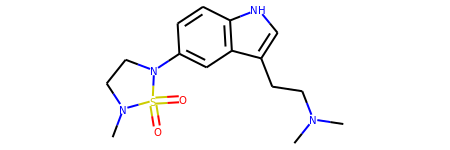

In [22]:
# taking SMILE from `training_set['SMILES structure'].iloc[1]`
molecule = Chem.MolFromSmiles('S1(=O)(=O)N(CCN1C)c1cc2c([nH]cc2CCN(C)C)cc1')

# Lets generate a rdk fingerprint, which is really a DataStructs.ExplicitBitVect
RDK_fp = RDKFingerprint(mol, fpSize=512)

# Draw the molecule
molecule

## Back to working with training_set

In [25]:
# Make an ndarray of lipophillicity values
lip_val_ndarr = training_set['experimental logD7.4'].values
# Make an array (really a pandas series) of fingerprints
mol_series = training_set['SMILES structure'].apply(Chem.MolFromSmiles)
RDK_fp_arr = mol_arr.apply(lambda mol: RDKFingerprint(mol, fpSize=512))